In [382]:
import numpy as np
from optic.models.devices import mzm, photodiode, edfa
from optic.models.channels import linearFiberChannel
from optic.comm.modulation import modulateGray
from optic.dsp.core import upsample, pulseShape, lowPassFIR, pnorm, signal_power

try:
    from optic.dsp.coreGPU import checkGPU
    if checkGPU():
        from optic.dsp.coreGPU import firFilter
    else:
        from optic.dsp.core import firFilter
except ImportError:
    from optic.dsp.core import firFilter

from optic.utils import parameters, dBm2W
from optic.plot import eyediagram
import matplotlib.pyplot as plt
from scipy.special import erfc
from tqdm.notebook import tqdm
import scipy as sp
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [383]:
figsize(10, 3)
np.random.seed(seed=123) # fixing the seed to get reproducible results

In [384]:
def simulate_system(Rs, label=''):
    SpS = 16                     # samples per symbol
    Fs = Rs * SpS               # sampling frequency
    Ts = 1 / Fs                 # sampling period

    # Laser power
    Pi_dBm = 0
    Pi = dBm2W(Pi_dBm)

    # MZM parameters
    paramMZM = parameters()
    paramMZM.Vpi = 2
    paramMZM.Vb = -paramMZM.Vpi / 2

    # Generate random bits and modulate
    bitsTx = np.random.randint(2, size=100000)
    symbTx = modulateGray(bitsTx, M=2, constType='pam')
    symbTx = pnorm(symbTx)

    # Upsample and shape pulse
    symbolsUp = upsample(symbTx, SpS)
    pulse = pulseShape('nrz', SpS)
    pulse = pulse / max(abs(pulse))
    sigTx = firFilter(pulse, symbolsUp)

    # Optical modulation
    Ai = np.sqrt(Pi)
    sigTxo = mzm(Ai, sigTx, paramMZM)

    # Time vector for plotting
    interval = np.arange(SpS*20, SpS*50)
    t = interval * Ts / 1e-9

    # Plot RF signal
    fig, axs = plt.subplots(1, 2, figsize=(16, 3))
    axs[0].set_xlim(-3*Rs, 3*Rs)
    axs[0].set_ylim(-180, -80)
    axs[0].psd(sigTx, Fs=Fs, NFFT=16*1024, sides='twosided', label=f'RF {label}')
    axs[0].legend(loc='upper left')
    axs[1].plot(t, sigTx[interval], label=f'RF {label}', linewidth=2)
    axs[1].set_ylabel('Amplitude (a.u.)')
    axs[1].set_xlabel('Time (ns)')
    axs[1].legend(loc='upper left')
    axs[1].grid()
    fig.suptitle(f"Electrical Signal (Rs = {Rs/1e9:.1f} GHz)")

    # Plot Optical Power
    fig, axs = plt.subplots(1, 2, figsize=(16, 3))
    axs[0].set_xlim(-3*Rs, 3*Rs)
    axs[0].set_ylim(-230, -130)
    axs[0].psd(np.abs(sigTxo)**2, Fs=Fs, NFFT=16*1024, sides='twosided', label=f'Optical {label}')
    axs[0].legend(loc='upper left')
    axs[1].plot(t, np.abs(sigTxo[interval])**2, label=f'Optical {label}', linewidth=2)
    axs[1].set_ylabel('Power (p.u.)')
    axs[1].set_xlabel('Time (ns)')
    axs[1].legend(loc='upper left')
    axs[1].grid()
    fig.suptitle(f"Optical Signal (Rs = {Rs/1e9:.1f} GHz)")

    # Return key signals and parameters
    return {
        'bitsTx': bitsTx,
        'sigTx': sigTx,
        'sigTxo': sigTxo,
        'Fs': Fs,
        'Rs': Rs,
        'SpS': SpS
    }


# Now you can access:
# result10['sigTx'], result10['Fs'], result10['bitsTx'], etc.

# For example, send result10['sigTxo'] into fiber channel


In [385]:
def apply_optical_channel(sigTxo, Fs, L_km=100, alpha_dB_per_km=0.2, D_ps_nm_km=16, Fc_Hz=193.1e12, NF_dB=4.5):
    # --- Channel Parameters ---
    paramCh = parameters()
    paramCh.L = L_km
    paramCh.α = alpha_dB_per_km
    paramCh.D = D_ps_nm_km
    paramCh.Fc = Fc_Hz
    paramCh.Fs = Fs

    # Apply linear fiber channel
    sigCh = linearFiberChannel(sigTxo, paramCh)

    # --- EDFA Amplifier Parameters ---
    paramEDFA = parameters()
    paramEDFA.G = paramCh.α * paramCh.L  # Gain to compensate for loss
    paramEDFA.NF = NF_dB
    paramEDFA.Fc = Fc_Hz
    paramEDFA.Fs = Fs

    # Apply EDFA
    sigCh = edfa(sigCh, paramEDFA)

    return sigCh


In [386]:
def apply_photodiode(signal, Fs, Rs, SpS, ideal=True, bandwidth=None, ipd_sat=5e-3):
    """
    Apply photodiode model to the input optical signal.
    
    Parameters:
    - signal: input optical signal (complex or real)
    - Fs: sampling frequency (samples/sec)
    - Rs: symbol rate (baud)
    - SpS: samples per symbol
    - ideal: True for ideal PD (noiseless, unlimited BW), False for noisy PD
    - bandwidth: bandwidth for noisy PD (set if ideal=False)
    - ipd_sat: photodiode saturation current for noisy PD
    
    Returns:
    - output current signal from photodiode
    """
    paramPD = parameters()
    paramPD.ideal = ideal
    paramPD.Fs = Fs
    
    if not ideal:
        paramPD.B = bandwidth if bandwidth is not None else Rs
        paramPD.ipd_sat = ipd_sat
    
    I_out = photodiode(signal.real if ideal else signal, paramPD)
    return I_out


In [387]:
def calculate_BER_and_plot(I_Rx, bitsTx, SpS, discard=100):
    # Normalize received signal
    I_Rx = I_Rx / np.std(I_Rx)

    # Capture samples in the middle of signaling intervals
    I_Rx_sampled = I_Rx[0::SpS]

    # Calculate received signal statistics
    I1 = np.mean(I_Rx_sampled[bitsTx == 1])
    I0 = np.mean(I_Rx_sampled[bitsTx == 0])

    σ1 = np.std(I_Rx_sampled[bitsTx == 1])
    σ0 = np.std(I_Rx_sampled[bitsTx == 0])

    # Optimal decision threshold
    Id = (σ1 * I0 + σ0 * I1) / (σ1 + σ0)

    # Q-factor
    Q = (I1 - I0) / (σ1 + σ0)

    print(f'I0 = {I0:.2f}')
    print(f'I1 = {I1:.2f}')
    print(f'σ0 = {σ0:.2f}')
    print(f'σ1 = {σ1:.2f}')
    print(f'Optimal decision threshold Id = {Id:.2f}')
    print(f'Q = {Q:.2f}\n')

    # Apply decision threshold
    bitsRx = np.empty(bitsTx.size, dtype=int)
    bitsRx[I_Rx_sampled > Id] = 1
    bitsRx[I_Rx_sampled <= Id] = 0

    # Discard edges for BER calculation
    err = np.logical_xor(bitsRx[discard:-discard], bitsTx[discard:-discard])
    BER = np.mean(err)

    # Theoretical bit error probability
    Pb = 0.5 * erfc(Q / np.sqrt(2))

    print(f'Number of counted errors = {err.sum()}')
    print(f'BER = {BER:.2e}')
    print(f'Pb (theoretical) = {Pb:.2e}')

    # Plot bit errors
    err_plot = err.astype(float)
    err_plot[err_plot == 0] = np.nan

    plt.figure(figsize=(10, 4))
    plt.plot(err_plot, 'o', label='bit errors')
    plt.vlines(np.where(err > 0), 0, 1, colors='r', lw=0.5)
    plt.xlabel('Bit position')
    plt.ylabel('Counted error')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1.5)
    plt.xlim(0, err_plot.size)
    plt.title('Bit Error Positions')
    plt.show()

    return {
        'BER': BER,
        'Pb_theoretical': Pb,
        'Q_factor': Q,
        'threshold_Id': Id,
        'I0_mean': I0,
        'I1_mean': I1,
        'sigma0': σ0,
        'sigma1': σ1
    }

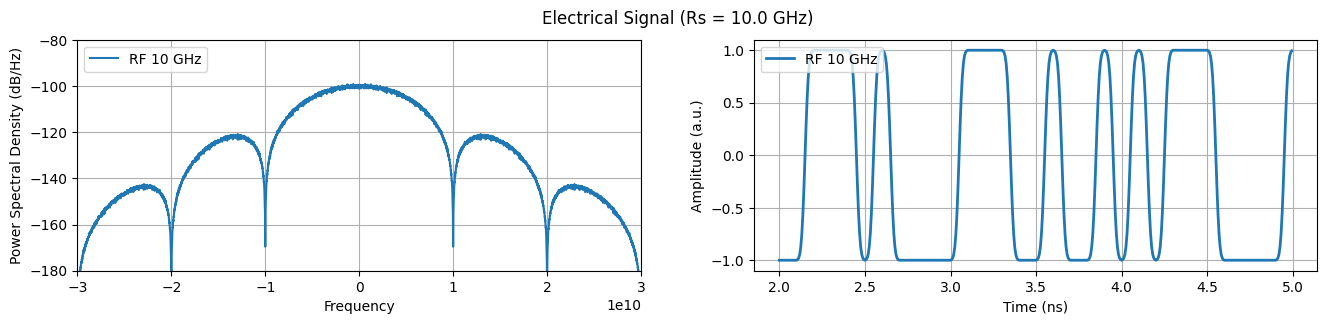

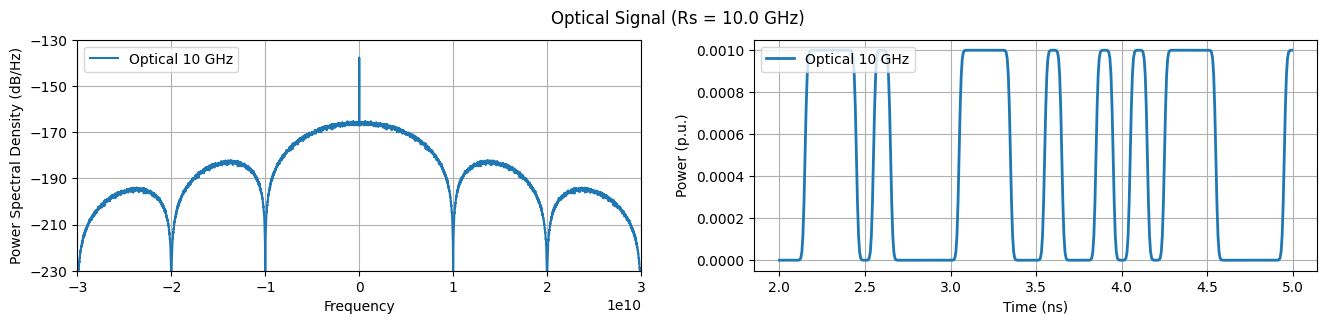

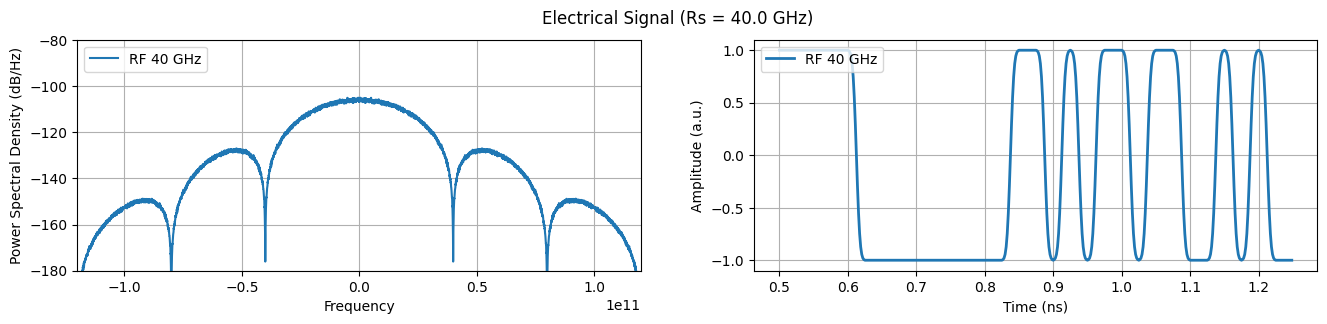

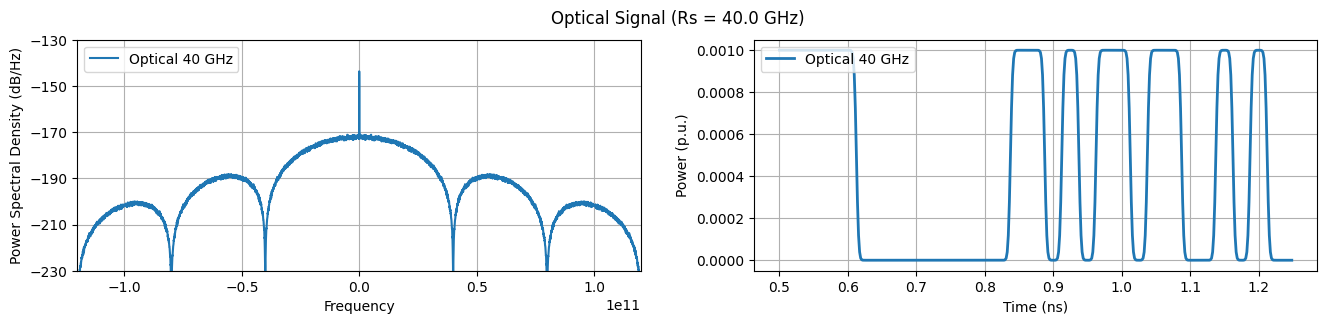

In [388]:
Rs10=10e9
Rs40=40e9
result10 = simulate_system(Rs10, label='10 GHz')
result40 = simulate_system(Rs40, label='40 GHz')

In [389]:
alpha_dB_per_km=0.2  # fiber loss parameter [dB/km]
D_ps_nm_km=16  # fiber dispersion parameter [ps/nm/km]
Fc_Hz=193.1e12  # central optical frequency [Hz]
NF_dB=4.5 # edfa noise figure 
receiver_bandwidth = None

L_values = [10, 30, 50, 70, 100]  # km

results_channel_10 = {}
results_channel_40 = {}

for L in L_values:
    results_channel_10[L] = apply_optical_channel(
        result10['sigTxo'],
        Fs=result10['Fs'],
        L_km=L,
        alpha_dB_per_km=alpha_dB_per_km,
        D_ps_nm_km=D_ps_nm_km,
        Fc_Hz=Fc_Hz,
        NF_dB=NF_dB
    )
    results_channel_40[L] = apply_optical_channel(
        result40['sigTxo'],
        Fs=result40['Fs'],
        L_km=L,
        alpha_dB_per_km=alpha_dB_per_km,
        D_ps_nm_km=D_ps_nm_km,
        Fc_Hz=Fc_Hz,
        NF_dB=NF_dB
    )


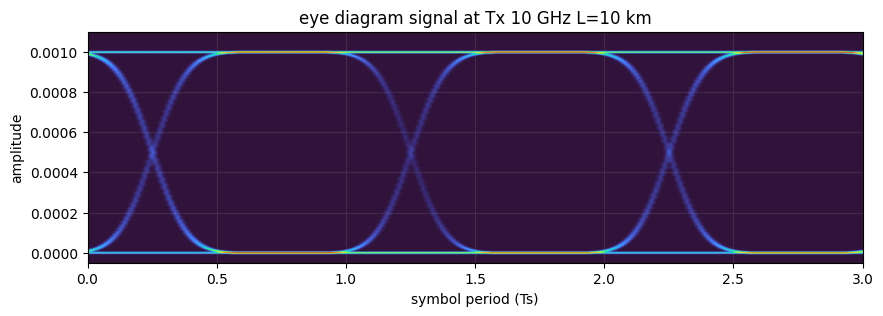

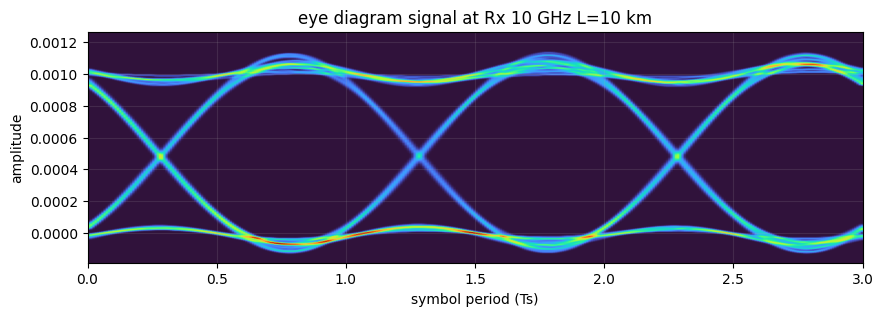

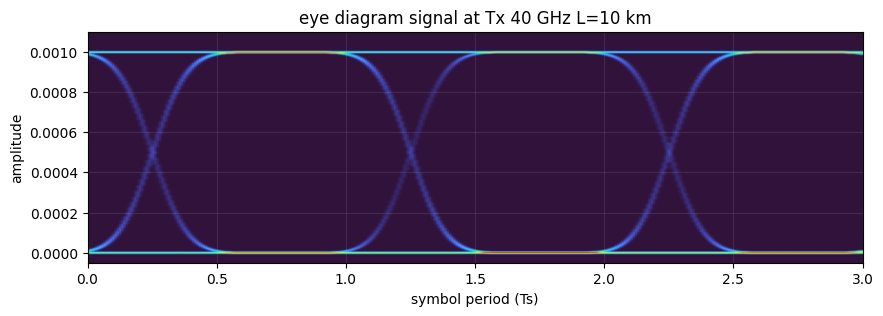

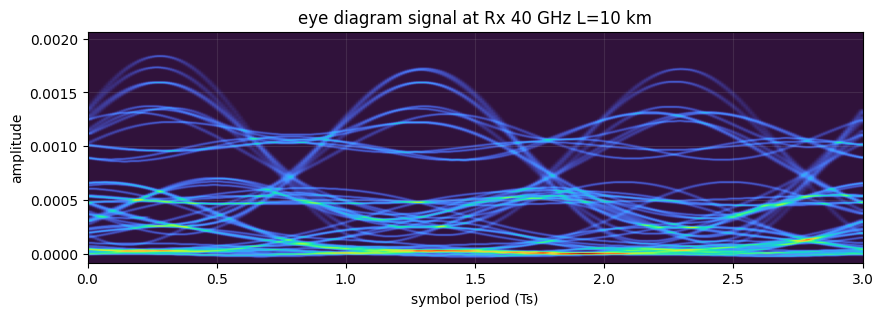

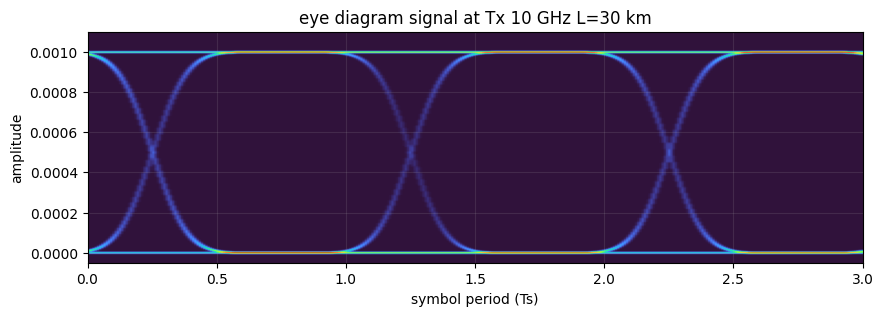

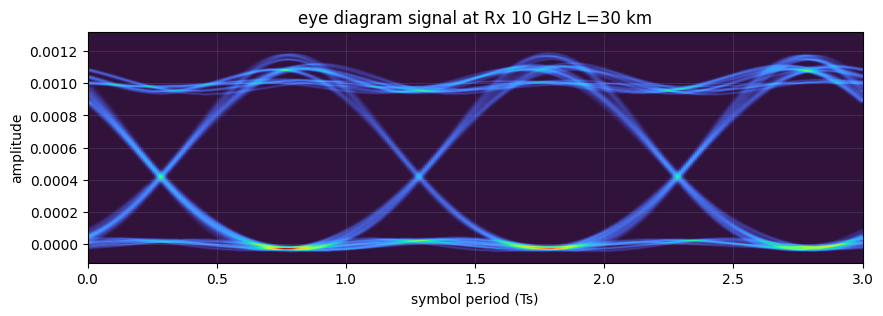

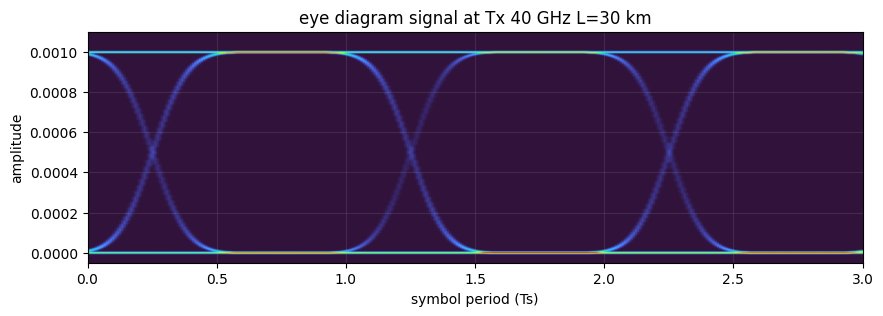

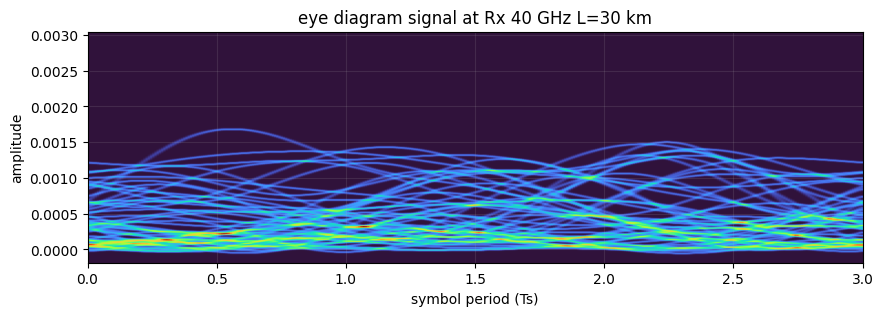

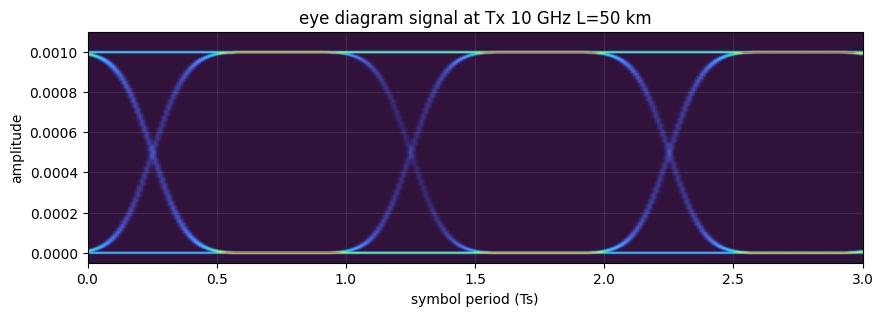

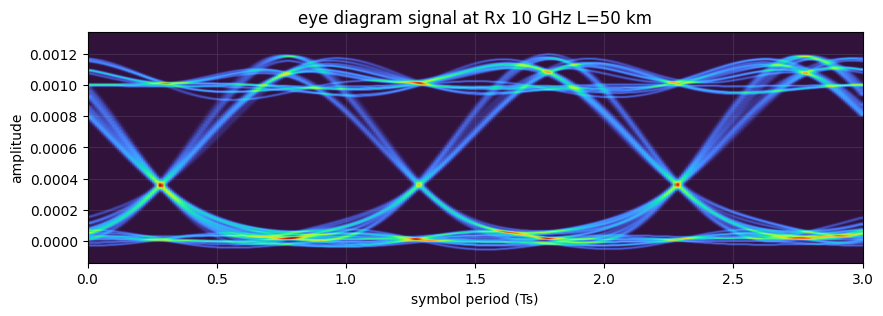

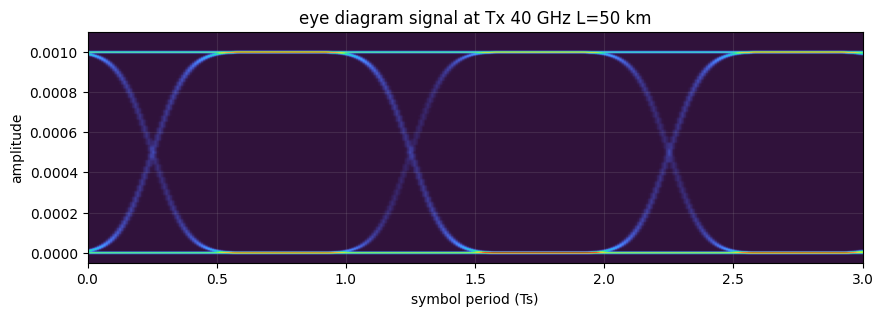

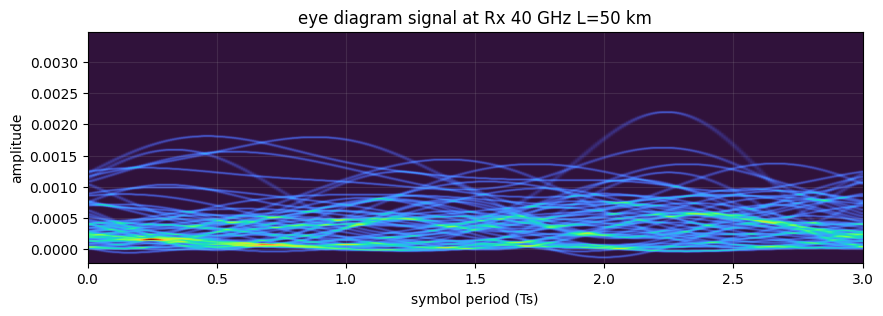

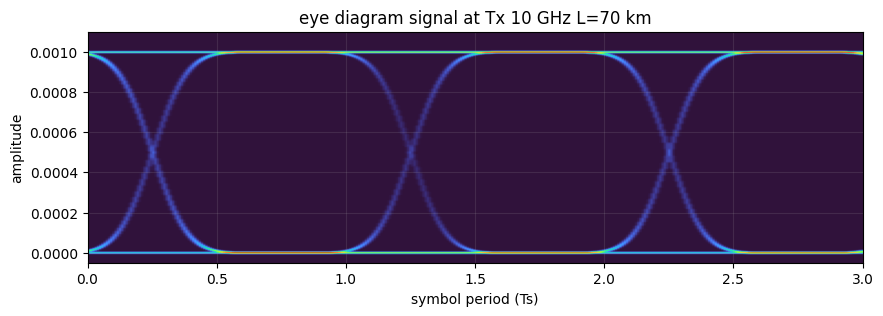

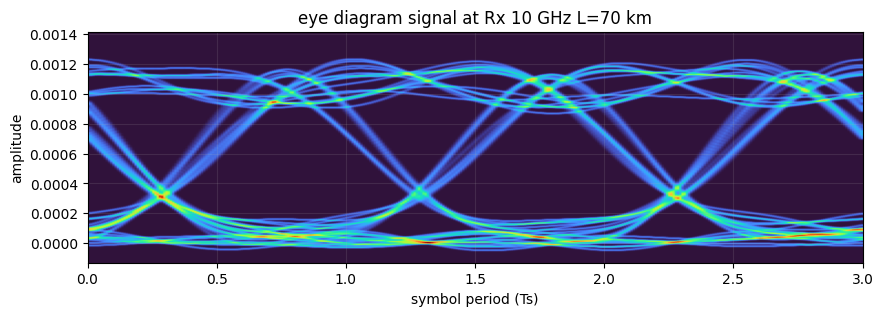

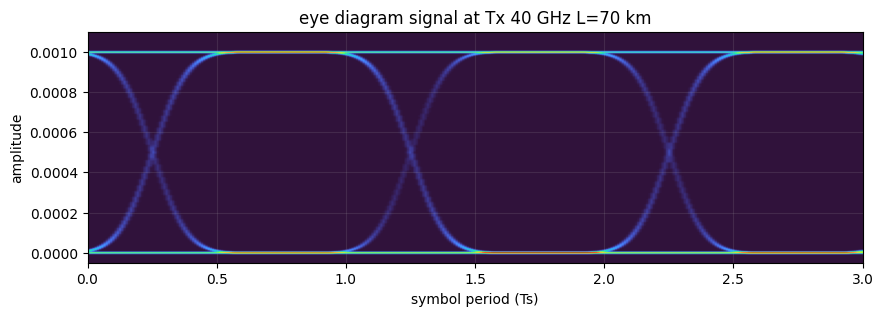

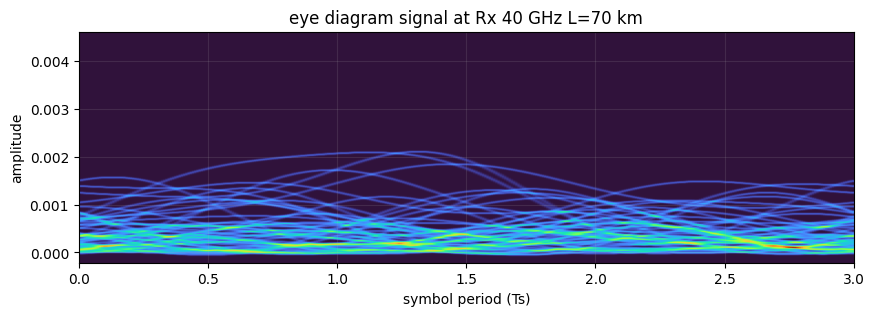

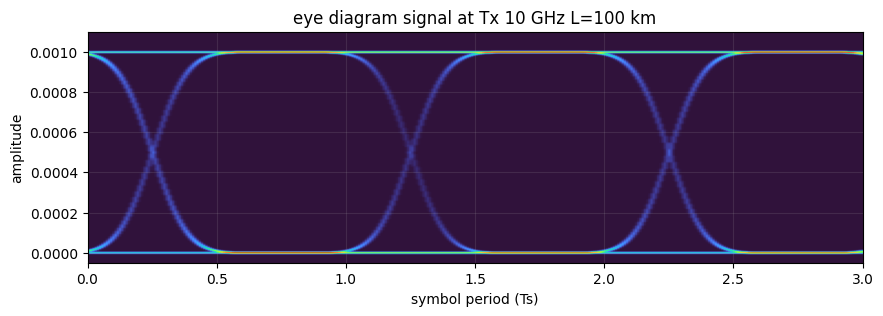

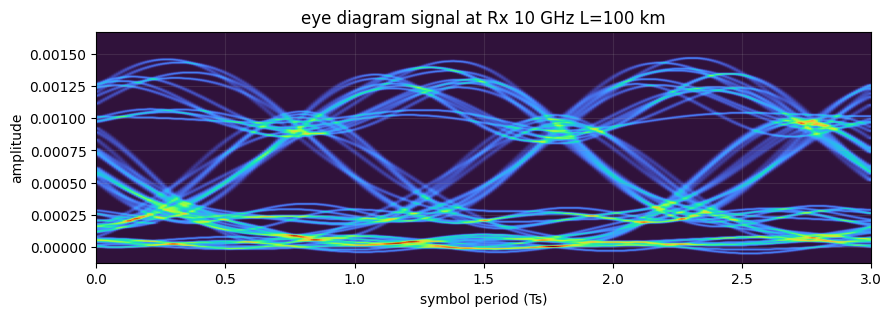

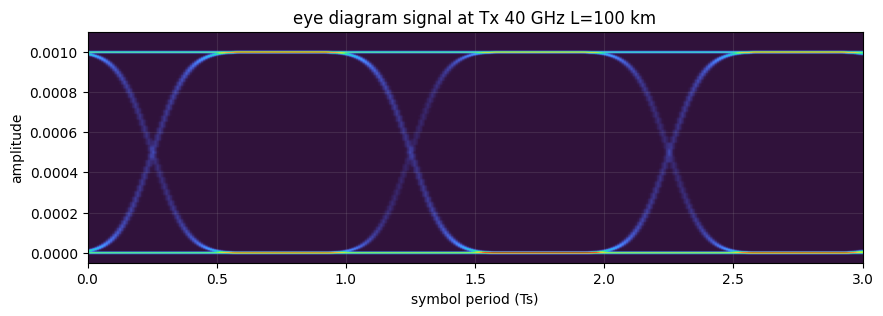

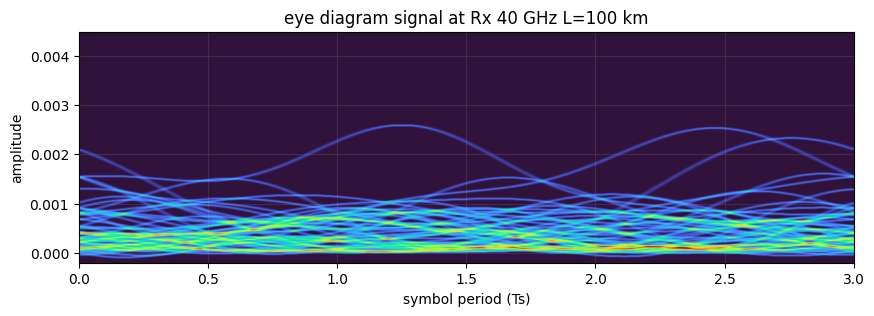

In [390]:
discard = 100
I_Rx_dict_10 = {}
I_Rx_dict_40 = {}


for L in L_values:
    # For 10 GHz
    sigCh10 = results_channel_10[L]
    I_Tx_10 = apply_photodiode(result10['sigTxo'], result10['Fs'], result10['Rs'], result10['SpS'], ideal=True, bandwidth=receiver_bandwidth)
    I_Rx_10 = apply_photodiode(sigCh10, result10['Fs'], result10['Rs'], result10['SpS'], ideal=False, bandwidth=receiver_bandwidth)
    
    eyediagram(I_Tx_10[discard:-discard], I_Tx_10.size - 2*discard, result10['SpS'],
               plotlabel=f'signal at Tx 10 GHz L={L} km', ptype='fancy')
    eyediagram(I_Rx_10[discard:-discard], I_Rx_10.size - 2*discard, result10['SpS'],
               plotlabel=f'signal at Rx 10 GHz L={L} km', ptype='fancy')
    
    # For 40 GHz
    sigCh40 = results_channel_40[L]
    I_Tx_40 = apply_photodiode(result40['sigTxo'], result40['Fs'], result40['Rs'], result40['SpS'], ideal=True, bandwidth=receiver_bandwidth)
    I_Rx_40 = apply_photodiode(sigCh40, result40['Fs'], result40['Rs'], result40['SpS'], ideal=False, bandwidth=receiver_bandwidth)
    I_Rx_dict_10[L] = I_Rx_10
    I_Rx_dict_40[L] = I_Rx_40
    eyediagram(I_Tx_40[discard:-discard], I_Tx_40.size - 2*discard, result40['SpS'],
               plotlabel=f'signal at Tx 40 GHz L={L} km', ptype='fancy')
    eyediagram(I_Rx_40[discard:-discard], I_Rx_40.size - 2*discard, result40['SpS'],
               plotlabel=f'signal at Rx 40 GHz L={L} km', ptype='fancy')


I0 = -0.14
I1 = 2.30
σ0 = 0.06
σ1 = 0.07
Optimal decision threshold Id = 0.93
Q = 18.46

Number of counted errors = 0
BER = 0.00e+00
Pb (theoretical) = 2.27e-76


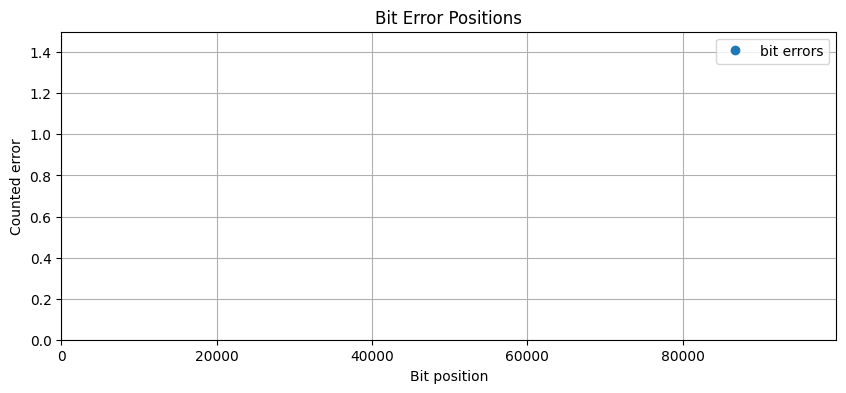

L=10 km, BER 10 GHz = 0.00e+00
..........
I0 = 0.45
I1 = 1.71
σ0 = 0.46
σ1 = 0.47
Optimal decision threshold Id = 1.07
Q = 1.36

Number of counted errors = 13192
BER = 1.32e-01
Pb (theoretical) = 8.69e-02


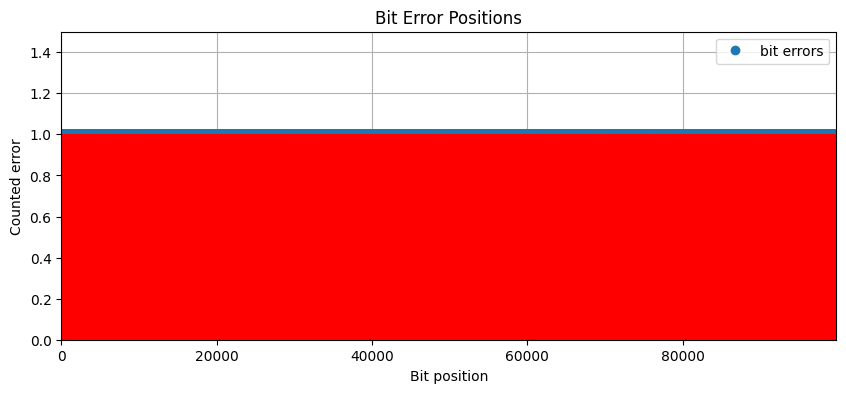

L=10 km, BER 40 GHz = 1.32e-01
------------------------------------------
I0 = -0.05
I1 = 2.36
σ0 = 0.02
σ1 = 0.12
Optimal decision threshold Id = 0.31
Q = 17.37

Number of counted errors = 0
BER = 0.00e+00
Pb (theoretical) = 6.93e-68


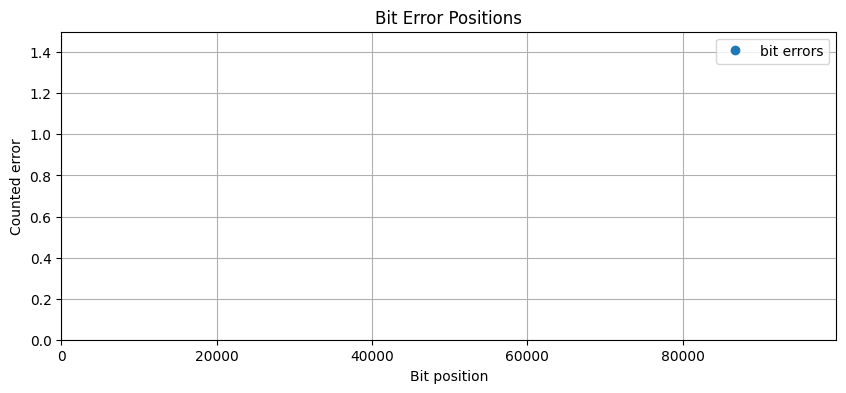

L=30 km, BER 10 GHz = 0.00e+00
..........
I0 = 0.80
I1 = 1.47
σ0 = 0.69
σ1 = 0.96
Optimal decision threshold Id = 1.08
Q = 0.41

Number of counted errors = 34703
BER = 3.48e-01
Pb (theoretical) = 3.43e-01


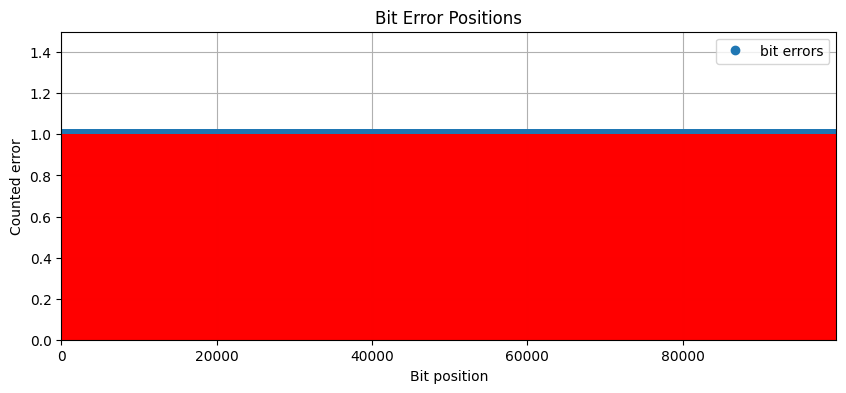

L=30 km, BER 40 GHz = 3.48e-01
------------------------------------------
I0 = 0.04
I1 = 2.36
σ0 = 0.06
σ1 = 0.15
Optimal decision threshold Id = 0.67
Q = 11.00

Number of counted errors = 0
BER = 0.00e+00
Pb (theoretical) = 1.95e-28


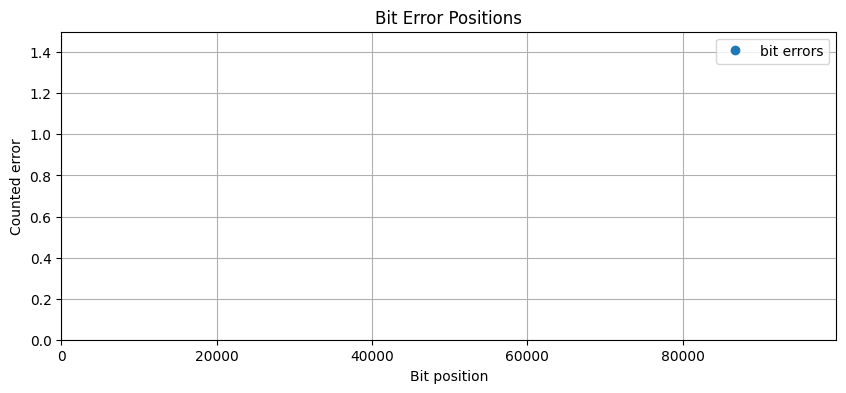

L=50 km, BER 10 GHz = 0.00e+00
..........
I0 = 0.90
I1 = 1.40
σ0 = 0.78
σ1 = 1.02
Optimal decision threshold Id = 1.12
Q = 0.28

Number of counted errors = 38592
BER = 3.87e-01
Pb (theoretical) = 3.90e-01


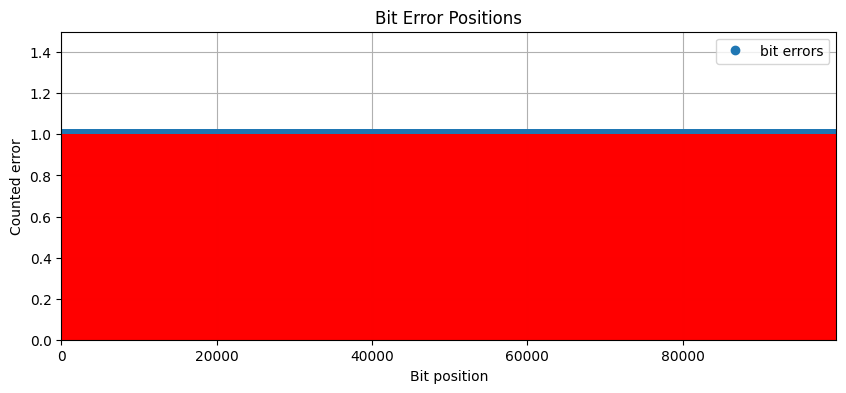

L=50 km, BER 40 GHz = 3.87e-01
------------------------------------------
I0 = 0.11
I1 = 2.30
σ0 = 0.11
σ1 = 0.16
Optimal decision threshold Id = 1.00
Q = 8.35

Number of counted errors = 0
BER = 0.00e+00
Pb (theoretical) = 3.44e-17


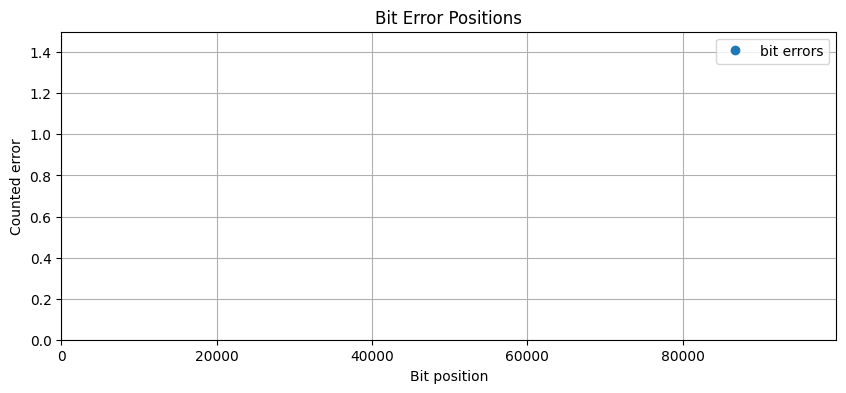

L=70 km, BER 10 GHz = 0.00e+00
..........
I0 = 0.96
I1 = 1.39
σ0 = 0.84
σ1 = 1.05
Optimal decision threshold Id = 1.15
Q = 0.23

Number of counted errors = 40630
BER = 4.07e-01
Pb (theoretical) = 4.09e-01


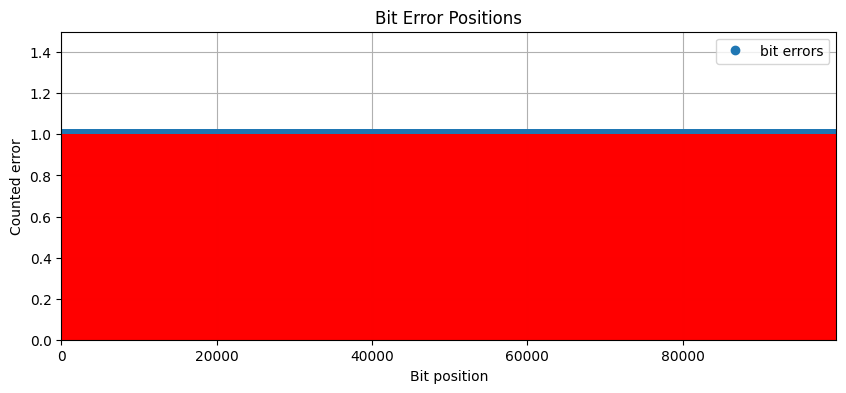

L=70 km, BER 40 GHz = 4.07e-01
------------------------------------------
I0 = 0.22
I1 = 2.12
σ0 = 0.22
σ1 = 0.15
Optimal decision threshold Id = 1.35
Q = 5.25

Number of counted errors = 0
BER = 0.00e+00
Pb (theoretical) = 7.48e-08


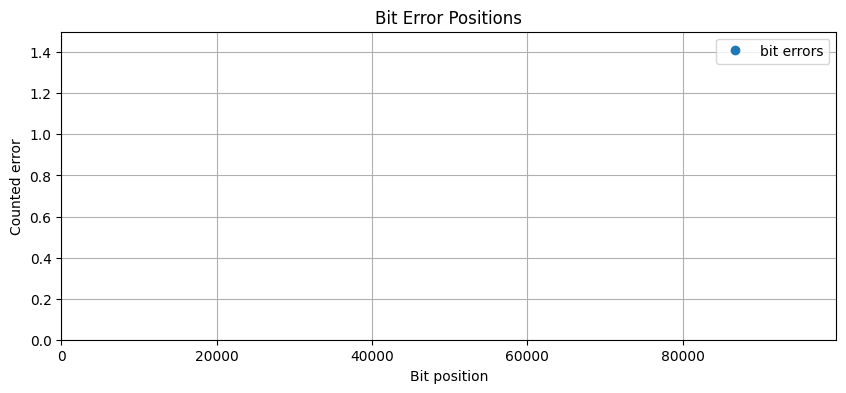

L=100 km, BER 10 GHz = 0.00e+00
..........
I0 = 1.04
I1 = 1.43
σ0 = 0.86
σ1 = 1.09
Optimal decision threshold Id = 1.21
Q = 0.20

Number of counted errors = 42089
BER = 4.22e-01
Pb (theoretical) = 4.22e-01


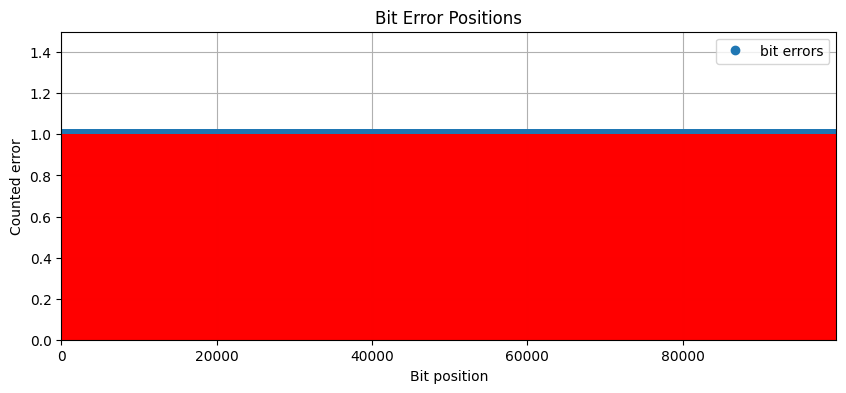

L=100 km, BER 40 GHz = 4.22e-01
------------------------------------------


In [391]:
ber_results_10 = {}
ber_results_40 = {}
discard = 100

for L in L_values:
    results10 = calculate_BER_and_plot(I_Rx_dict_10[L], result10['bitsTx'], result10['SpS'], discard=discard)
    ber_results_10[L] = results10['BER']
    print(f"L={L} km, BER 10 GHz = {results10['BER']:.2e}")
    print("..........")
    results40 = calculate_BER_and_plot(I_Rx_dict_40[L], result40['bitsTx'], result40['SpS'], discard=discard)
    ber_results_40[L] = results40['BER']
    print(f"L={L} km, BER 40 GHz = {results40['BER']:.2e}")
    print("------------------------------------------")



In [392]:
print("--------------SUMMARY--------")
print(f"{'L (km)':>6} | {'D (ps/nm/km)':>14} | {'Receiver BW (GHz)':>17} | {'BER 10 GHz':>12} | {'BER 40 GHz':>12} | {'EDFA NF (dB)':>12}")
print("-" * 90)

for L in L_values:
    ber10 = ber_results_10[L]
    ber40 = ber_results_40[L]
    
    if receiver_bandwidth is None:
        bw_display = "None"
    else:
        bw_display = f"{receiver_bandwidth/1e9:.1f}"
        
    print(f"{L:6d} | {D_ps_nm_km:14.1f} | {bw_display:17} | {ber10:12.2e} | {ber40:12.2e} | {NF_dB:12.1f}")

print("-" * 90)

--------------SUMMARY--------
L (km) |   D (ps/nm/km) | Receiver BW (GHz) |   BER 10 GHz |   BER 40 GHz | EDFA NF (dB)
------------------------------------------------------------------------------------------
    10 |           16.0 | None              |     0.00e+00 |     1.32e-01 |          4.5
    30 |           16.0 | None              |     0.00e+00 |     3.48e-01 |          4.5
    50 |           16.0 | None              |     0.00e+00 |     3.87e-01 |          4.5
    70 |           16.0 | None              |     0.00e+00 |     4.07e-01 |          4.5
   100 |           16.0 | None              |     0.00e+00 |     4.22e-01 |          4.5
------------------------------------------------------------------------------------------


In [393]:
# results10 = calculate_BER_and_plot(result10_I_Rx, result10['bitsTx'], result10['SpS'])
# print(f"BER at this setting: {results10['BER']}")
# results40 = calculate_BER_and_plot(result40_I_Rx, result40['bitsTx'], result40['SpS'])
# print(f"BER at this setting: {results40['BER']}")